In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import pickle
from pathlib import Path
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/AL/Phd/maxml/caloml-atlas/'
plotpath = path_prefix+'regression/Plots_dset/'
modelpath = path_prefix+'regression/Models/'

# import our resolution utilities
import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

Using TensorFlow backend.


In [3]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Convolution3D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import MaxPool3D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model
from tensorflow import keras as keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model
import keras.backend as K

import tensorflow as tf
from sklearn.metrics import roc_curve, auc

gpu_list = ["/gpu:0"]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [4]:
def baseline_nn_All_model():
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels + 2
        model.add(Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'))
        model.add(Dense(used_pixels, activation='relu'))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])
    return model

In [5]:
inputpath = path_prefix+'inputs/'
ptypes = ["piplus"] #["pi0", "piplus", "piminus"]
training_classes = ['pi0','piplus']
cell_shapes = {
    'EMB1': (128,4),
    'EMB2': (16,16),
    'EMB3': (8,16),
    'TileBar0': (4,4),
    'TileBar1': (4,4),
    'TileBar2': (2,4),
}

# fancy display names for each pion type
pi_latex = {
    'pi0': '\(\pi^{0}\)',
    'piplus': '\(\pi^{+}\)',
    'piminus': '\(\pi^{-}\)',
}

def test_dataset(dataset,filename='',
                 epochs=100, average=False):
    if( filename == '' ):
        filename = dataset+"_piplus"

    trees = {
        ptype : ur.open(inputpath+ptype+'.root')['ClusterTree']
        for ptype in ptypes
    }
    branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
    pdata = {
        ptype : itree.pandas.df(branches, flatten=False)
        for ptype, itree in trees.items()
    }
    
    for ptype in ptypes:
        pdata[ptype]['clusterEoverCalib'] = pdata[ptype].clusterE / pdata[ptype].cluster_ENG_CALIB_TOT
        pdata[ptype]['clusterEoverTruth'] = pdata[ptype].clusterE / pdata[ptype].truthE
        pdata[ptype]['cluster_ENG_ALL'] = pdata[ptype].cluster_ENG_CALIB_TOT + pdata[ptype].cluster_ENG_CALIB_OUT_T + pdata[ptype].cluster_ENG_CALIB_DEAD_TOT

    for ptype in ptypes:
        pdata[ptype]['logE'] = np.log(pdata[ptype].clusterE)
        pdata[ptype]['logECalib'] = np.log(pdata[ptype].cluster_ENG_CALIB_TOT)
        pdata[ptype]['logECalibAll'] = np.log(pdata[ptype].cluster_ENG_ALL)
        
    scaler_cal = {}
    for ptype in ptypes:
        # create scaler
        scaler_e = StandardScaler()
        scaler_cal[ptype] = StandardScaler()
        scaler_calAll = StandardScaler()
        # fit and transform in one step
        pdata[ptype]['s_logE'] = scaler_e.fit_transform(pdata[ptype]['logE'].to_numpy().reshape(-1,1))
        pdata[ptype]['s_logECalib'] = scaler_cal[ptype].fit_transform(pdata[ptype]['logECalib'].to_numpy().reshape(-1,1))
        pdata[ptype]['s_logECalibAll'] = scaler_calAll.fit_transform(pdata[ptype]['logECalibAll'].to_numpy().reshape(-1,1))

    # fun cleaning for EMProb
    epsilon = 0.000000000001
    for ptype in ptypes:
        pdata[ptype]['cluster_fixEM'] = pdata[ptype].cluster_EM_PROBABILITY.replace(to_replace=0,value=epsilon)
        
    for ptype in ptypes:
        pdata[ptype]['cluster_logEM'] = np.log(pdata[ptype].cluster_fixEM)

        scaler_EM = StandardScaler()
        pdata[ptype]['s_logEM'] = scaler_EM.fit_transform(pdata[ptype].cluster_logEM.to_numpy().reshape(-1,1))

        scaler_eta = StandardScaler()
        pdata[ptype]['s_eta'] = scaler_eta.fit_transform(pdata[ptype].clusterEta.to_numpy().reshape(-1,1))

        pdata[ptype]['logCenter'] = np.log(pdata[ptype].cluster_CENTER_MAG)
        scaler_center = StandardScaler()
        pdata[ptype]['s_logCenter'] = scaler_center.fit_transform(pdata[ptype].logCenter.to_numpy().reshape(-1,1))

        scaler_density = StandardScaler()
        pdata[ptype]['s_Density'] = scaler_density.fit_transform(pdata[ptype].cluster_FIRST_ENG_DENS.to_numpy().reshape(-1,1))

    for ptype in ptypes:
        pdata[ptype]['Single'] = pdata[ptype].nCluster==1 # define a subset of events with only one cluster
        mu.splitFrameTVT(pdata[ptype], trainfrac = 0.7)   # define a train/test fraction of 70/20% (10% for val at this point)
        
    All_input = {}
    for ptype in ptypes:
        EMB1_cells = mu.setupCells(trees[ptype], 'EMB1') # implicitly flatten
        EMB2_cells = mu.setupCells(trees[ptype], 'EMB2')
        EMB3_cells = mu.setupCells(trees[ptype], 'EMB3') # implicitly flatten

        TileBar0_cells = mu.setupCells(trees[ptype], 'TileBar0') # implicitly flatten
        TileBar1_cells = mu.setupCells(trees[ptype], 'TileBar1') # implicitly flatten
        TileBar2_cells = mu.setupCells(trees[ptype], 'TileBar2') # implicitly flatten

        combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
        s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
        All_input[ptype] = np.column_stack((pdata[ptype]['s_logE'],pdata[ptype]['s_eta'],s_All_cells))
        
    # check if model has been trained already
    if Path(modelpath+filename+'.h5').is_file():
        # load model
        model = tf.keras.models.load_model(modelpath+filename+".h5")
    else:
        # train model
        model = baseline_nn_All_model()
        f_history = model.fit(
            All_input['piplus'][pdata['piplus'].train],
            pdata['piplus'][pdata['piplus'].train].s_logECalib.to_numpy(),
            batch_size=200*ngpu, epochs=epochs
        )
        f_history = f_history.history
        
        # save trained weights and history
        if(filename != ''):
            model.save(modelpath+filename+".h5")
            with open(modelpath+filename +".history",'wb') as model_history_file:
                pickle.dump(f_history, model_history_file)
                
    pdata['piplus'][dataset] = np.exp(
        scaler_cal['piplus'].inverse_transform(model.predict(All_input['piplus']))
    )
    pdata['piplus'][dataset+'_EoverCalib'] = pdata['piplus'][dataset] / pdata['piplus'].cluster_ENG_CALIB_TOT
    
    xcenter, med = ru.responsePlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT,
                  pdata['piplus'][pdata['piplus'].test][ds+'_EoverCalib'], 
                  figfile = plotpath+filename+'_response.pdf', statistic = 'median',
                  xlabel = 'Cluster Calib Hits', ylabel = 'Pred. Energy / Calib Hits',
                  atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                  textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8, 'text': ds.replace('_','-')}])
    
    xcenter, res = ru.resolutionPlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT, 
                        pdata['piplus'][pdata['piplus'].test][ds+'_EoverCalib'], statistic='iqrOverMed')
    return xcenter, med, res

c:\users\akong\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


<Figure size 576x432 with 0 Axes>

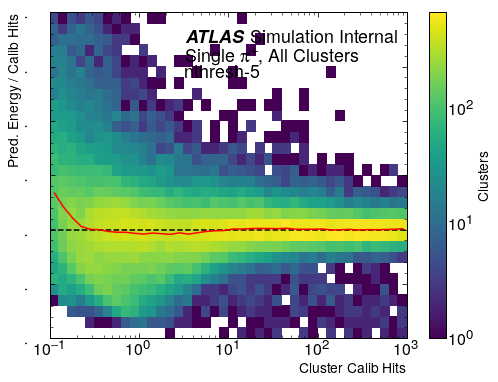

<Figure size 576x432 with 0 Axes>

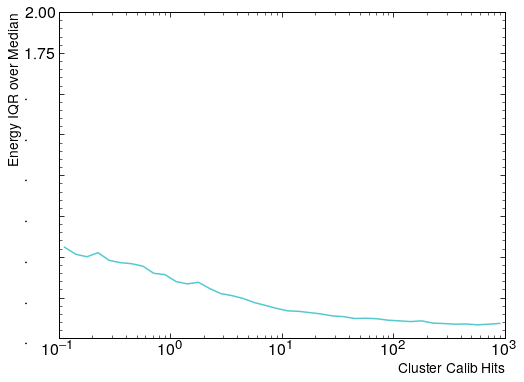

c:\users\akong\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


<Figure size 576x432 with 0 Axes>

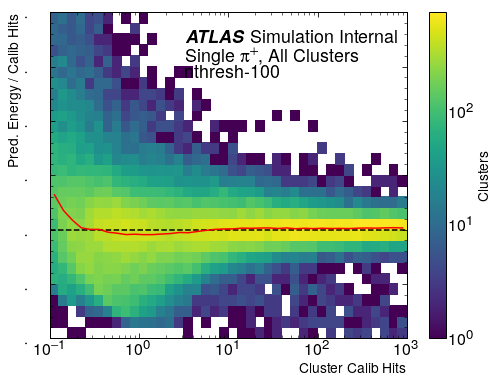

<Figure size 576x432 with 0 Axes>

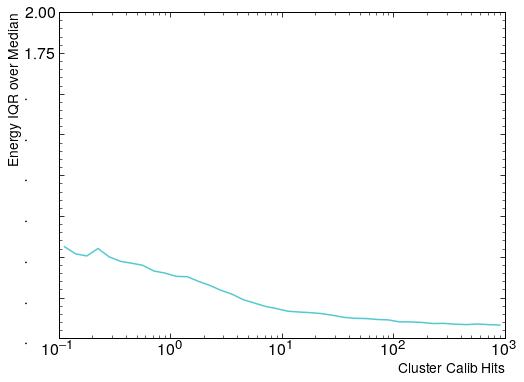

c:\users\akong\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


<Figure size 576x432 with 0 Axes>

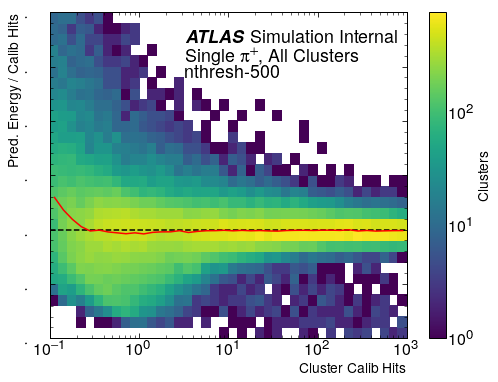

<Figure size 576x432 with 0 Axes>

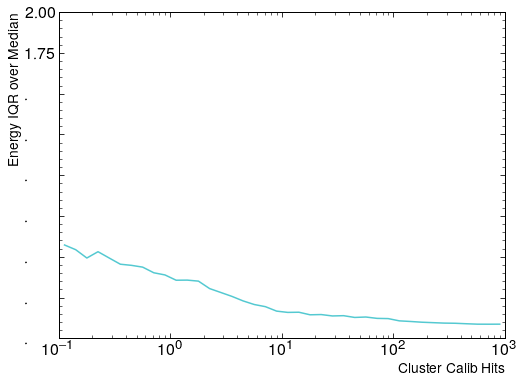

c:\users\akong\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


<Figure size 576x432 with 0 Axes>

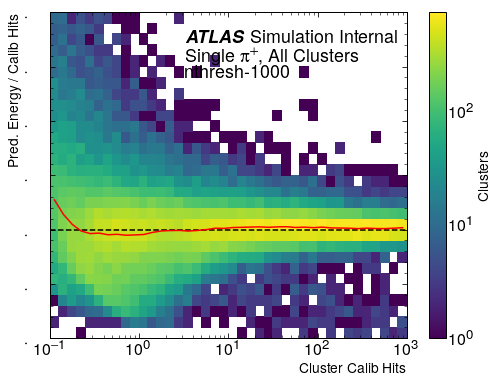

<Figure size 576x432 with 0 Axes>

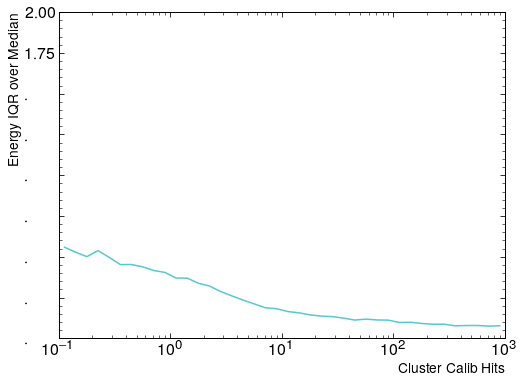

<Figure size 576x432 with 0 Axes>

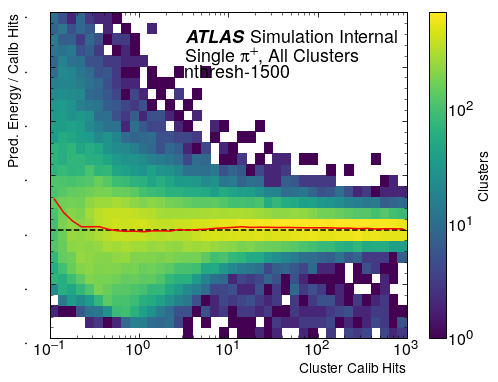

<Figure size 576x432 with 0 Axes>

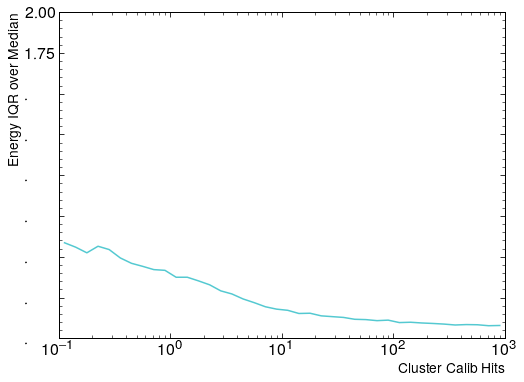

c:\users\akong\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


<Figure size 576x432 with 0 Axes>

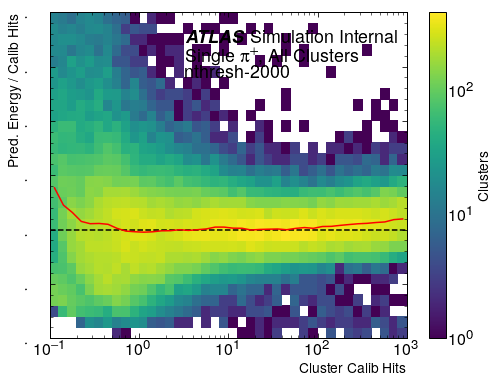

<Figure size 576x432 with 0 Axes>

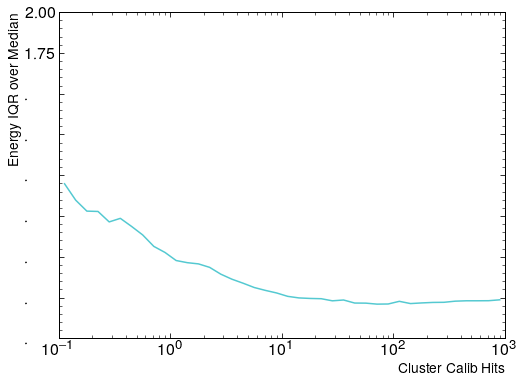

In [13]:
# dsets = ['nthresh_0','nthresh_2','nthresh_5','nthresh_10','nthresh_norm','nthresh_none']
# tvals = ['0 MeV','2 MeV','5 MeV','10 MeV','norm','none']
dsets = ['nthresh_5', 'nthresh_100', 'nthresh_500', 'nthresh_1000', 'nthresh_1500', 'nthresh_2000']
tvals = ['5 MeV', '100 MeV', '500 MeV', '1 GeV', '1.5 GeV', '2 GeV']


medians = []
resolutions = []
for ds in dsets:
    xcenter, med, res = test_dataset(ds, epochs=20)
    medians.append(med)
    resolutions.append(res)

<Figure size 576x432 with 0 Axes>

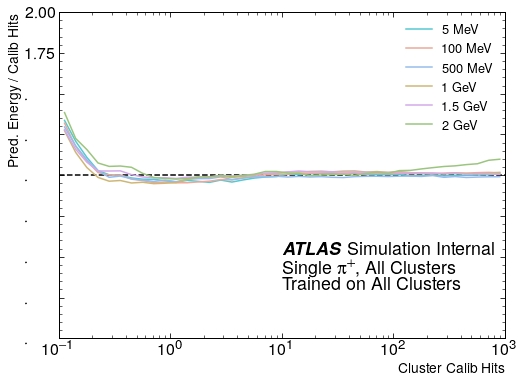

In [14]:
pu.lineOverlay(xcenter=xcenter, lines = medians,
                labels = tvals,
                xlabel = 'Cluster Calib Hits', ylabel = 'Pred. Energy / Calib Hits',
                figfile = plotpath + "dataset_overlay_high.pdf",
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.5, 'y': 0.15, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

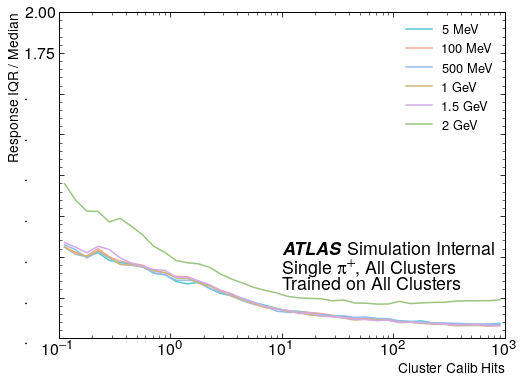

In [15]:
pu.lineOverlay(xcenter=xcenter, lines = resolutions,
                labels = tvals,
                xlabel = 'Cluster Calib Hits', ylabel = 'Response IQR / Median',
                figfile = plotpath + "dataset_res_overlay_high.pdf",
                #extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.5, 'y': 0.15, 'text': 'Trained on All Clusters'}])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Train on 305176 samples
Epoch 1/20
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/de

<Figure size 576x432 with 0 Axes>

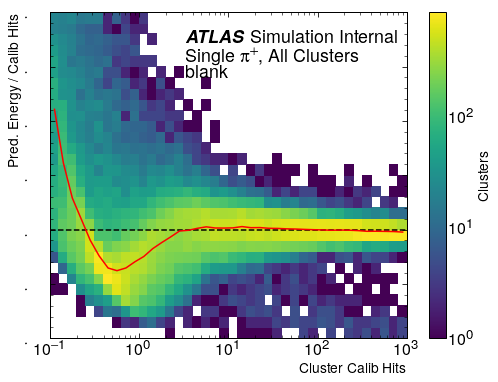

<Figure size 576x432 with 0 Axes>

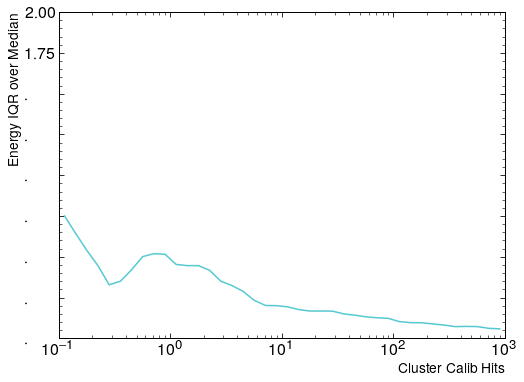

In [6]:
ptypes = ["piplus"]
trees = {
    ptype : ur.open(inputpath+ptype+'.root')['ClusterTree']
    for ptype in ptypes
}
branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
pdata = {
    ptype : itree.pandas.df(branches, flatten=False)
    for ptype, itree in trees.items()
}

for ptype in ptypes:
    pdata[ptype]['clusterEoverCalib'] = pdata[ptype].clusterE / pdata[ptype].cluster_ENG_CALIB_TOT
    pdata[ptype]['clusterEoverTruth'] = pdata[ptype].clusterE / pdata[ptype].truthE
    pdata[ptype]['cluster_ENG_ALL'] = pdata[ptype].cluster_ENG_CALIB_TOT + pdata[ptype].cluster_ENG_CALIB_OUT_T + pdata[ptype].cluster_ENG_CALIB_DEAD_TOT

for ptype in ptypes:
    pdata[ptype]['logE'] = np.log(pdata[ptype].clusterE)
    pdata[ptype]['logECalib'] = np.log(pdata[ptype].cluster_ENG_CALIB_TOT)
    pdata[ptype]['logECalibAll'] = np.log(pdata[ptype].cluster_ENG_ALL)

scaler_cal = {}
for ptype in ptypes:
    # create scaler
    scaler_e = StandardScaler()
    scaler_cal[ptype] = StandardScaler()
    scaler_calAll = StandardScaler()
    # fit and transform in one step
    pdata[ptype]['s_logE'] = scaler_e.fit_transform(pdata[ptype]['logE'].to_numpy().reshape(-1,1))
    pdata[ptype]['s_logECalib'] = scaler_cal[ptype].fit_transform(pdata[ptype]['logECalib'].to_numpy().reshape(-1,1))
    pdata[ptype]['s_logECalibAll'] = scaler_calAll.fit_transform(pdata[ptype]['logECalibAll'].to_numpy().reshape(-1,1))

# fun cleaning for EMProb
epsilon = 0.000000000001
for ptype in ptypes:
    pdata[ptype]['cluster_fixEM'] = pdata[ptype].cluster_EM_PROBABILITY.replace(to_replace=0,value=epsilon)

for ptype in ptypes:
    pdata[ptype]['cluster_logEM'] = np.log(pdata[ptype].cluster_fixEM)

    scaler_EM = StandardScaler()
    pdata[ptype]['s_logEM'] = scaler_EM.fit_transform(pdata[ptype].cluster_logEM.to_numpy().reshape(-1,1))

    scaler_eta = StandardScaler()
    pdata[ptype]['s_eta'] = scaler_eta.fit_transform(pdata[ptype].clusterEta.to_numpy().reshape(-1,1))

    pdata[ptype]['logCenter'] = np.log(pdata[ptype].cluster_CENTER_MAG)
    scaler_center = StandardScaler()
    pdata[ptype]['s_logCenter'] = scaler_center.fit_transform(pdata[ptype].logCenter.to_numpy().reshape(-1,1))

    scaler_density = StandardScaler()
    pdata[ptype]['s_Density'] = scaler_density.fit_transform(pdata[ptype].cluster_FIRST_ENG_DENS.to_numpy().reshape(-1,1))

for ptype in ptypes:
    pdata[ptype]['Single'] = pdata[ptype].nCluster==1 # define a subset of events with only one cluster
    mu.splitFrameTVT(pdata[ptype], trainfrac = 0.7)   # define a train/test fraction of 70/20% (10% for val at this point)

All_input = {}
blank_input = {}
for ptype in ptypes:
    EMB1_cells = mu.setupCells(trees[ptype], 'EMB1') # implicitly flatten
    EMB2_cells = mu.setupCells(trees[ptype], 'EMB2')
    EMB3_cells = mu.setupCells(trees[ptype], 'EMB3') # implicitly flatten

    TileBar0_cells = mu.setupCells(trees[ptype], 'TileBar0') # implicitly flatten
    TileBar1_cells = mu.setupCells(trees[ptype], 'TileBar1') # implicitly flatten
    TileBar2_cells = mu.setupCells(trees[ptype], 'TileBar2') # implicitly flatten

    combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
    combine_blank_cells = np.zeros((435967, 936))
    s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
    s_blank_cells, scaler_blank_cells = mu.standardCells(combine_blank_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
    All_input[ptype] = np.column_stack((pdata[ptype]['s_logE'],pdata[ptype]['s_eta'],s_All_cells))
    blank_input[ptype] = np.column_stack((pdata[ptype]['s_logE'],pdata[ptype]['s_eta'],s_blank_cells))

# All_input = {}
# All_input['piplus'] = np.zeros((435967, 938))

# check if model has been trained already
if Path(modelpath+'blank'+'.h5').is_file():
    # load model
    model = tf.keras.models.load_model(modelpath+'blank'+".h5")
else:
    # train model
    model = baseline_nn_All_model()
    f_history = model.fit(
        blank_input['piplus'][pdata['piplus'].train],
        pdata['piplus'][pdata['piplus'].train].s_logECalib.to_numpy(),
        batch_size=200*ngpu, epochs=20
    )
    f_history = f_history.history

    # save trained weights and history
    model.save(modelpath+'blank'+".h5")
    with open(modelpath+'blank' +".history",'wb') as model_history_file:
        pickle.dump(f_history, model_history_file)

# pdata['piplus']['blank'] = np.exp(
#     scaler_cal['piplus'].inverse_transform(model.predict(All_input['piplus']))
# )
pdata['piplus']['blank'] = np.exp(
    scaler_cal['piplus'].inverse_transform(model.predict(blank_input['piplus']))
)

pdata['piplus']['blank'+'_EoverCalib'] = pdata['piplus']['blank'] / pdata['piplus'].cluster_ENG_CALIB_TOT

xcenter, med = ru.responsePlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT,
              pdata['piplus'][pdata['piplus'].test]['blank'+'_EoverCalib'], 
              figfile = plotpath+'blank'+'_response.pdf', statistic = 'median',
              xlabel = 'Cluster Calib Hits', ylabel = 'Pred. Energy / Calib Hits',
              atlas_x = 0.38, atlas_y = 0.95, simulation = True,
              textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                         {'x': 0.38, 'y': 0.8, 'text': 'blank'}])

xcenter, res = ru.resolutionPlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT, 
                    pdata['piplus'][pdata['piplus'].test]['blank'+'_EoverCalib'], statistic='iqrOverMed',
                    figfile = plotpath+'blank'+'_resolution.pdf')
